<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [1]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

import warnings

warnings.filterwarnings('ignore')

sns.set(style="darkgrid", font_scale=1.4)

/raid/luchkin/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'


# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [2]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

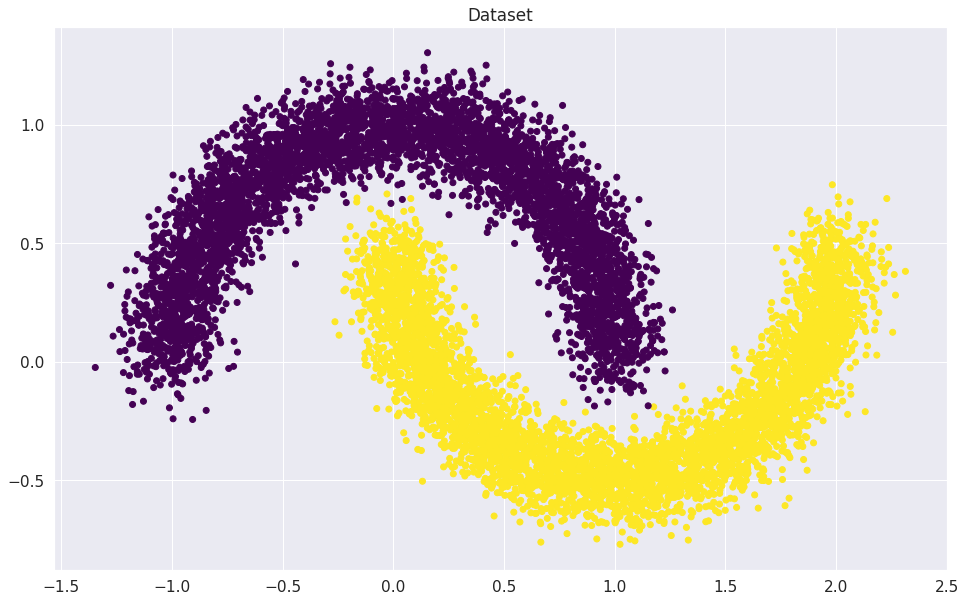

In [3]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [5]:
X_train_t = torch.FloatTensor(X_train) # YOUR CODE GOES HERE
y_train_t =  torch.FloatTensor(y_train)# YOUR CODE GOES HERE
X_val_t =  torch.FloatTensor(X_val)# YOUR CODE GOES HERE
y_val_t =  torch.FloatTensor(y_val)# YOUR CODE GOES HERE

Создаем `Dataset` и `DataLoader`. 

In [6]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут 
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [7]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.rand(1))# YOUR CODE GOES HERE

    def forward(self, x):
        x = x @ self.weights # YOUR CODE GOES HERE
        if self.bias:
            x += self.bias_term # YOUR CODE GOES HERE
        return x

In [8]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели?

In [9]:
print(f'\033[1;32mОтвет: {len (list(linear_regression.parameters()))}')#YOUR CODE

Ответ: 2


### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обнуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [10]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp =  linear_regression(X_batch)# YOUR CODE. Use linear_regression to get outputs
        loss =  loss_function(outp, y_batch)# YOUR CODE. Compute loss
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities =  torch.sigmoid(outp)# YOUR CODE. Compute probabilities
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
        
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.8515625
Iteration: 100
Batch accuracy: 0.8828125
Iteration: 200
Batch accuracy: 0.859375
Iteration: 300
Batch accuracy: 0.921875
Iteration: 400
Batch accuracy: 0.890625
Iteration: 500
Batch accuracy: 0.9140625

Iteration: 519.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

In [11]:
print(f'\033[1;32mОтвет: {it + epoch * len(train_dataloader)} итераций')

Ответ: 519 итераций


### Визуализируем результаты

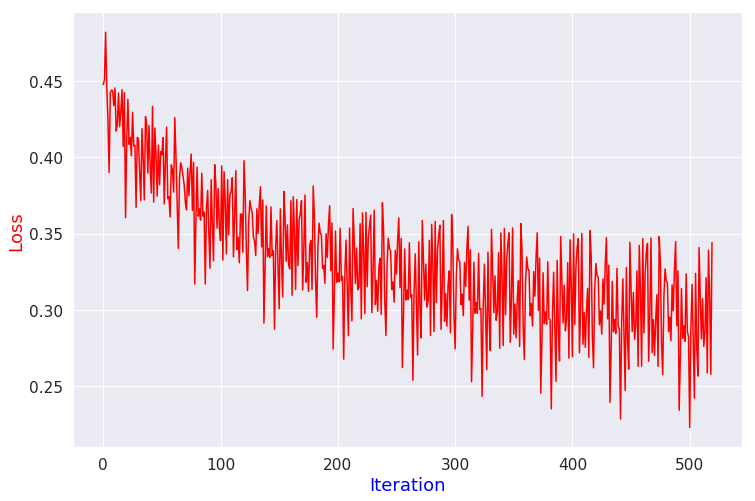

In [12]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses, color = 'red')
plt.xlabel("Iteration", fontsize=18, color = 'blue')
plt.ylabel("Loss", fontsize=18, color = 'red')
plt.show()

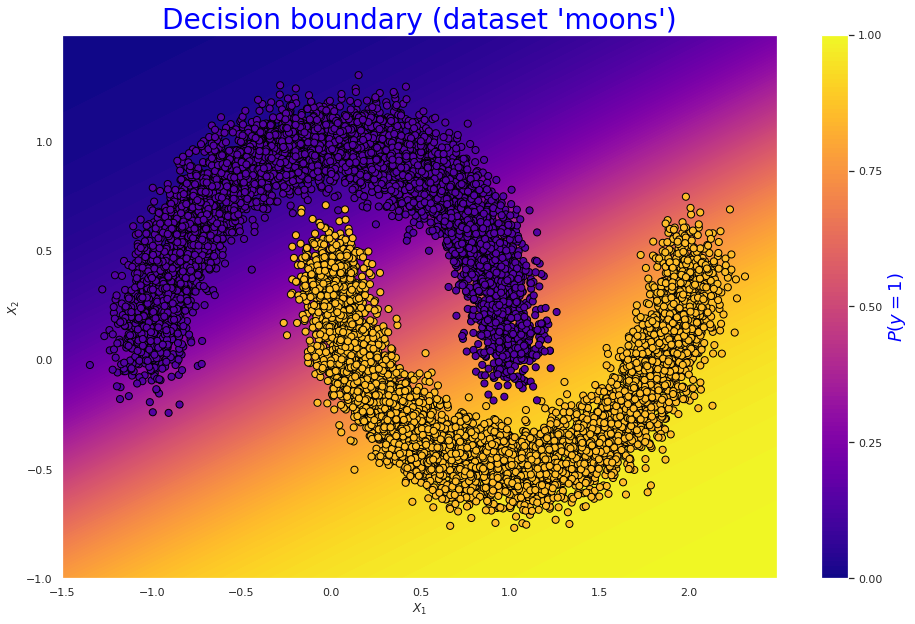

In [13]:
import numpy as np

sns.set(style="dark")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary (dataset 'moons')", fontsize=28, color = 'blue')
contour = ax.contourf(xx, yy, probs, 150, cmap="plasma",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$", fontsize=18, color = 'blue')
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="plasma", vmin=-.2, vmax=1.2,
           edgecolor="black", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [14]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        #<YOUR CODE>
        outp = linear_regression(x_batch)
        preds = (torch.sigmoid(outp) > 0.5) #YOUR CODE. Compute predictions
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

**Вопрос 3**

Какое `accuracy` получается после обучения?

In [15]:
from sklearn.metrics import accuracy_score

# YOUR CODE. Compute total accuracy
z = predict(val_dataloader, linear_regression)
z.shape

print(f'\033[1;32mОтвет: accuracy = {accuracy_score(z,y_val)}')

Ответ: accuracy = 0.8736


# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [16]:
import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs

data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader = DataLoader(train_dataset, batch_size=128,
                                          shuffle=True, num_workers=2, drop_last=True) # YOUR CODE GOES HERE
valid_dataloader = DataLoader(val_dataset, batch_size=128,
                                         shuffle=False, num_workers=2, drop_last=True) # YOUR CODE GOES HERE

## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

### Задание. Простая полносвязная нейронная сеть 

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [18]:
D_in, H, D_out = 784, 128, 10
activation = nn.ELU()

model = nn.Sequential(
    nn.Flatten(),
    #YOUR CODE. Add layers to your sequential class
    torch.nn.Linear(D_in, H),
    activation,
    torch.nn.Linear(H, D_out),
    activation,
    torch.nn.Softmax()
).to(device)

In [19]:
criterion = nn.CrossEntropyLoss().to(device) #YOUR CODE. Select a loss function
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [20]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                optimizer.zero_grad() # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
                outp = model(x_batch.to(device))                     
            else:
                 with torch.no_grad():# YOUR CODE. Set model to ``eval`` mode and calculate outputs
                        outp = model(x_batch.to(device))
                        
            preds = outp.argmax(-1)
            correct = (preds == y_batch.to(device)).squeeze() # YOUR CODE GOES HERE
            all = 128 # YOUR CODE GOES HERE
            epoch_correct += sum(correct)
            epoch_all += all
            
            if k == "train":
                # forward + backward + optimize
                loss = criterion(outp, y_batch.to(device))
                loss.backward() # YOUR CODE. Calculate gradients and make a step of your optimizer
                optimizer.step()
                
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all) 


Epoch: 1
Loader: train. Accuracy: 0.8234509229660034
Loader: valid. Accuracy: 0.9137620329856873
Epoch: 2
Loader: train. Accuracy: 0.9136618971824646
Loader: valid. Accuracy: 0.9244791865348816
Epoch: 3
Loader: train. Accuracy: 0.9302884936332703
Loader: valid. Accuracy: 0.9389022588729858
Epoch: 4
Loader: train. Accuracy: 0.9432425498962402
Loader: valid. Accuracy: 0.9443109035491943
Epoch: 5
Loader: train. Accuracy: 0.9505375623703003
Loader: valid. Accuracy: 0.9518229365348816
Epoch: 6
Loader: train. Accuracy: 0.9571982026100159
Loader: valid. Accuracy: 0.9567307829856873
Epoch: 7
Loader: train. Accuracy: 0.9618055820465088
Loader: valid. Accuracy: 0.9595352411270142
Epoch: 8
Loader: train. Accuracy: 0.9656283855438232
Loader: valid. Accuracy: 0.9602363705635071
Epoch: 9
Loader: train. Accuracy: 0.9679654836654663
Loader: valid. Accuracy: 0.9625400900840759
Epoch: 10
Loader: train. Accuracy: 0.9713374972343445
Loader: valid. Accuracy: 0.9673477411270142


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [21]:
elu_accuracy = accuracy["valid"]

In [22]:
# YOUR CODE. Do the same thing with other activations (it's better to wrap into a function that returns a list of accuracies)

def test_activation_function(activation = None):    
    #YOUR CODE
    if activation:
        print(activation)
        new_model = nn.Sequential(
            nn.Flatten(),
            torch.nn.Linear(D_in, H),
            activation,
            torch.nn.Linear(H, D_out),
            activation,
            torch.nn.Softmax()
        ).to(device)
    else:
        print("Plain")
        new_model = nn.Sequential(
            nn.Flatten(),
            torch.nn.Linear(D_in, H),
            torch.nn.Linear(H, D_out),
            torch.nn.Softmax()
        ).to(device)
    criterion = nn.CrossEntropyLoss().to(device) #YOUR CODE. Select a loss function
    optimizer = torch.optim.Adam(new_model.parameters())    
    
    max_epochs = 10
    accuracy = {"train": [], "valid": []}
    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                if k == "train":
                    optimizer.zero_grad() # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
                    outp = new_model(x_batch.to(device))                     
                else:
                     with torch.no_grad():# YOUR CODE. Set model to ``eval`` mode and calculate outputs
                            outp = new_model(x_batch.to(device))
                            
                preds = outp.argmax(-1)
                correct = (preds == y_batch.to(device)).squeeze() # YOUR CODE GOES HERE
                all = 128 # YOUR CODE GOES HERE
                epoch_correct += sum(correct)
                epoch_all += all
                
                if k == "train":
                    # forward + backward + optimize
                    loss = criterion(outp, y_batch.to(device))
                    loss.backward() # YOUR CODE. Calculate gradients and make a step of your optimizer
                    optimizer.step()
                    
            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct/epoch_all) 
    return accuracy["valid"]

In [23]:
plain_accuracy = test_activation_function()

Plain
Epoch: 1
Loader: train. Accuracy: 0.8261719346046448
Loader: valid. Accuracy: 0.8984375
Epoch: 2
Loader: train. Accuracy: 0.9042468667030334
Loader: valid. Accuracy: 0.9111578464508057
Epoch: 3
Loader: train. Accuracy: 0.9096888899803162
Loader: valid. Accuracy: 0.9128605723381042
Epoch: 4
Loader: train. Accuracy: 0.9115752577781677
Loader: valid. Accuracy: 0.9181690812110901
Epoch: 5
Loader: train. Accuracy: 0.9149472713470459
Loader: valid. Accuracy: 0.9166666865348816
Epoch: 6
Loader: train. Accuracy: 0.9161825776100159
Loader: valid. Accuracy: 0.9150640964508057
Epoch: 7
Loader: train. Accuracy: 0.9161658883094788
Loader: valid. Accuracy: 0.9181690812110901
Epoch: 8
Loader: train. Accuracy: 0.9171842336654663
Loader: valid. Accuracy: 0.9246795177459717
Epoch: 9
Loader: train. Accuracy: 0.9188201427459717
Loader: valid. Accuracy: 0.9164663553237915
Epoch: 10
Loader: train. Accuracy: 0.9195546507835388
Loader: valid. Accuracy: 0.9130609035491943


In [24]:
relu_accuracy = test_activation_function(nn.ReLU())

ReLU()
Epoch: 1
Loader: train. Accuracy: 0.5237547159194946
Loader: valid. Accuracy: 0.5793269276618958
Epoch: 2
Loader: train. Accuracy: 0.6568509936332703
Loader: valid. Accuracy: 0.6895031929016113
Epoch: 3
Loader: train. Accuracy: 0.7010717391967773
Loader: valid. Accuracy: 0.7122395634651184
Epoch: 4
Loader: train. Accuracy: 0.7164463400840759
Loader: valid. Accuracy: 0.716646671295166
Epoch: 5
Loader: train. Accuracy: 0.7245092391967773
Loader: valid. Accuracy: 0.7308694124221802
Epoch: 6
Loader: train. Accuracy: 0.7314704060554504
Loader: valid. Accuracy: 0.7340745329856873
Epoch: 7
Loader: train. Accuracy: 0.7378472685813904
Loader: valid. Accuracy: 0.7380809187889099
Epoch: 8
Loader: train. Accuracy: 0.741653323173523
Loader: valid. Accuracy: 0.7423878312110901
Epoch: 9
Loader: train. Accuracy: 0.7477297186851501
Loader: valid. Accuracy: 0.7479968070983887
Epoch: 10
Loader: train. Accuracy: 0.7489316463470459
Loader: valid. Accuracy: 0.7484976053237915


In [25]:
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU())

LeakyReLU(negative_slope=0.01)
Epoch: 1
Loader: train. Accuracy: 0.7425047159194946
Loader: valid. Accuracy: 0.8243189454078674
Epoch: 2
Loader: train. Accuracy: 0.8864517211914062
Loader: valid. Accuracy: 0.9270833730697632
Epoch: 3
Loader: train. Accuracy: 0.9302217364311218
Loader: valid. Accuracy: 0.9289863705635071
Epoch: 4
Loader: train. Accuracy: 0.9412059783935547
Loader: valid. Accuracy: 0.9420072436332703
Epoch: 5
Loader: train. Accuracy: 0.949068546295166
Loader: valid. Accuracy: 0.9488181471824646
Epoch: 6
Loader: train. Accuracy: 0.9546608328819275
Loader: valid. Accuracy: 0.9512219429016113
Epoch: 7
Loader: train. Accuracy: 0.9593850374221802
Loader: valid. Accuracy: 0.9592347741127014
Epoch: 8
Loader: train. Accuracy: 0.9631410837173462
Loader: valid. Accuracy: 0.9592347741127014
Epoch: 9
Loader: train. Accuracy: 0.9666800498962402
Loader: valid. Accuracy: 0.9606370329856873
Epoch: 10
Loader: train. Accuracy: 0.9698517918586731
Loader: valid. Accuracy: 0.9654447436332703

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

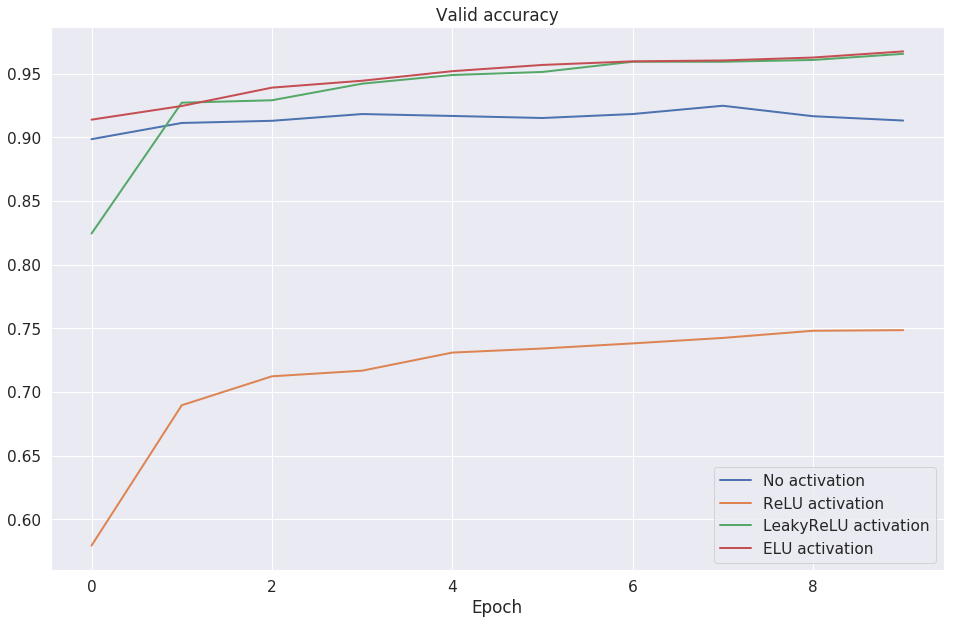

In [26]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

In [27]:
d = {'No activation': 0, 'ReLU activation': 1, 'LeakyReLU activation': 2, 'ELU activation': 3}
maximum = (np.array([plain_accuracy[-1].item(),relu_accuracy[-1].item(),
               leaky_relu_accuracy[-1].item(), elu_accuracy[-1].item()])).argmax(0)
for el in d:
    if maximum == d[el]:
        print(f'\033[1;32mОтвет: {el}')

Ответ: ELU activation


## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [28]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2022-03-22 17:59:47--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 144.76.208.75
Connecting to img.the-village.kz (img.the-village.kz)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg [following]
--2022-03-22 17:59:48--  https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village-kz.com (img.the-village-kz.com)... 144.76.208.75
Connecting to img.the-village-kz.com (img.the-village-kz.com)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K  --.-KB/s    in 0.1s    

2022-03-22 17:59:48 (462 KB/s) - ‘sample_photo.jpg’ saved [49337/4

(415, 620, 3)


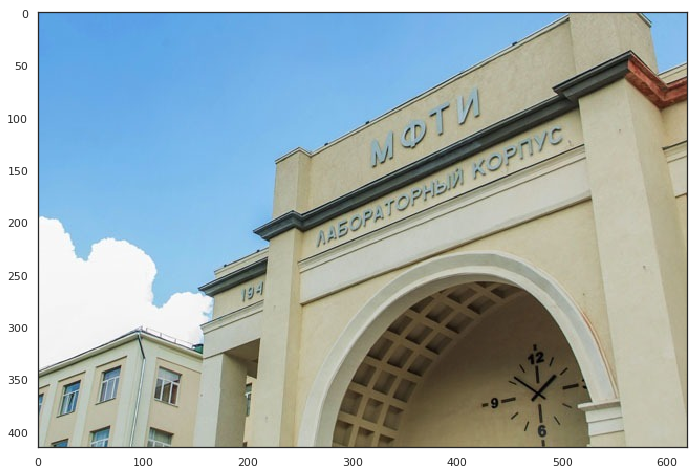

In [29]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
print(img.shape)
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте

A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [30]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0, 0, 0],
    [1, -2, 1],
    [0, 0, 0]
]).type(torch.float32)
kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size
result = F.conv2d(img_t, kernel)[0]  #

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(415, 620, 3)


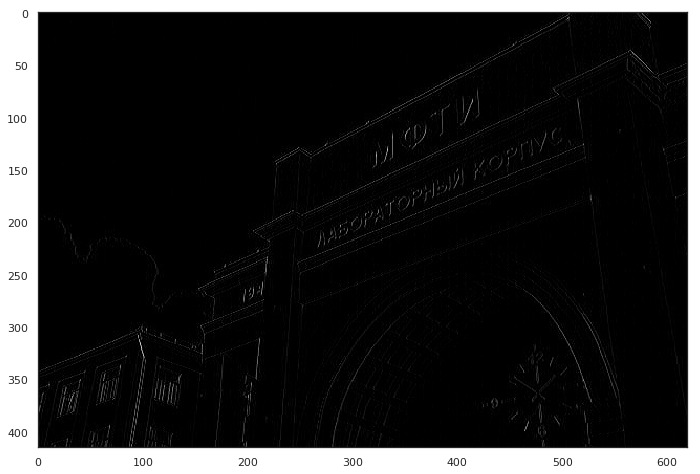

In [31]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3
print(result_np.shape)
plt.imshow(result_np)
plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:** 

    А)3 
    Б)5 
    В)4 
    Г)6 
    Д)2 
    Е)1

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential). 

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [32]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)#YOUR CODE
        # 6 input image channel, 16 output channels, 3x3 square conv kernel
        self.conv2 = nn.Conv2d(6, 16, 3)#YOUR CODE
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)#YOUR CODE
        self.fc1 = nn.Linear(400, 120)#YOUR CODE  
        self.fc2 = nn.Linear(120, 84)#YOUR CODE
        self.fc3 = nn.Linear(84, 10)#YOUR CODE

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))#YOUR CODE. Apply layers created in __init__.
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(128, -1)  # !!!
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [33]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [34]:
#<YOUR CODE>
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                optimizer.zero_grad() # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
                outp = model(x_batch.to(device))                     
            else:
                 with torch.no_grad():# YOUR CODE. Set model to ``eval`` mode and calculate outputs
                        outp = model(x_batch.to(device))
            preds = outp.argmax(-1)
            correct = (preds == y_batch.to(device)).squeeze() # YOUR CODE GOES HERE
            all = 128 # YOUR CODE GOES HERE
            epoch_correct += sum(correct)
            epoch_all += all
            
            if k == "train":
                # forward + backward + optimize
                loss = criterion(outp, y_batch.to(device))
                loss.backward() # YOUR CODE. Calculate gradients and make a step of your optimizer
                optimizer.step()
                
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all) 

Epoch: 1
Loader: train. Accuracy: 0.8776376247406006
Loader: valid. Accuracy: 0.9591346383094788
Epoch: 2
Loader: train. Accuracy: 0.9697516560554504
Loader: valid. Accuracy: 0.98046875
Epoch: 3
Loader: train. Accuracy: 0.9795005917549133
Loader: valid. Accuracy: 0.9818710088729858
Epoch: 4
Loader: train. Accuracy: 0.983890950679779
Loader: valid. Accuracy: 0.9848757982254028
Epoch: 5
Loader: train. Accuracy: 0.9863949418067932
Loader: valid. Accuracy: 0.9842748641967773
Epoch: 6
Loader: train. Accuracy: 0.9878973364830017
Loader: valid. Accuracy: 0.9856771230697632
Epoch: 7
Loader: train. Accuracy: 0.9905015230178833
Loader: valid. Accuracy: 0.9868789911270142
Epoch: 8
Loader: train. Accuracy: 0.9911859631538391
Loader: valid. Accuracy: 0.9875801205635071
Epoch: 9
Loader: train. Accuracy: 0.9929053783416748
Loader: valid. Accuracy: 0.9867788553237915
Epoch: 10
Loader: train. Accuracy: 0.9928553104400635
Loader: valid. Accuracy: 0.9868789911270142


In [35]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

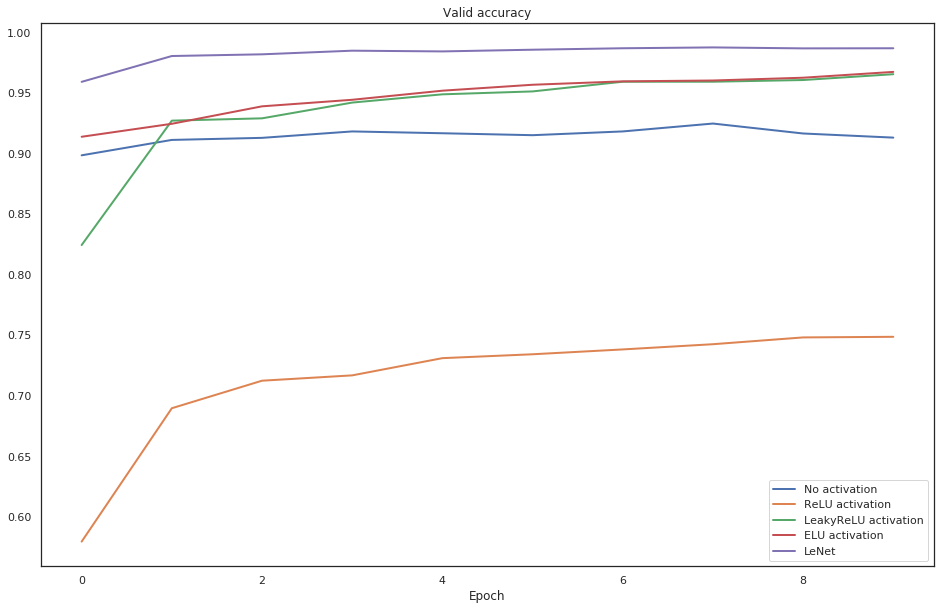

In [36]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:**

In [37]:
print(f'\033[1;32mОтвет: accuracy = {round(lenet_accuracy[-1].item(), 2)}')

Ответ: accuracy = 0.99
